# Neuroevolution on EvoGym

## Getting started

Check that the following line can run. If so, you have evogym installed! Otherwise, you need to install it.

In [25]:
from evogym import sample_robot
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import animation
import gymnasium as gym
import evogym.envs
from evogym import sample_robot
from evogym.utils import get_full_connectivity
from tqdm import tqdm

## Agent

In [26]:
class Network(nn.Module):
    def __init__(self, n_in, h_size, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, n_out)
 
        self.n_out = n_out

    def reset(self):
        pass
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x

In [27]:
class Agent:
    def __init__(self, Net, config, genes = None):
        self.config = config
        self.Net = Net
        self.model = None
        self.fitness = None

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

        self.make_network()
        if genes is not None:
            self.genes = genes

    def __repr__(self):  # pragma: no cover
        return f"Agent {self.model} > fitness={self.fitness}"

    def __str__(self):  # pragma: no cover
        return self.__repr__()

    def make_network(self):
        n_in = self.config["n_in"]
        h_size = self.config["h_size"]
        n_out = self.config["n_out"]
        self.model = self.Net(n_in, h_size, n_out).to(self.device).double()
        return self

    @property
    def genes(self):
        if self.model is None:
            return None
        with torch.no_grad():
            params = self.model.parameters()
            vec = torch.nn.utils.parameters_to_vector(params)
        return vec.cpu().double().numpy()

    @genes.setter
    def genes(self, params):
        if self.model is None:
            self.make_network()
        assert len(params) == len(
            self.genes), "Genome size does not fit the network size"
        if np.isnan(params).any():
            raise
        a = torch.tensor(params, device=self.device)
        torch.nn.utils.vector_to_parameters(a, self.model.parameters())
        self.model = self.model.to(self.device).double()
        self.fitness = None
        return self

    def mutate_ga(self):
        genes = self.genes
        n = len(genes)
        f = np.random.choice([False, True], size=n, p=[1/n, 1-1/n])
        
        new_genes = np.empty(n)
        new_genes[f] = genes[f]
        noise = np.random.randn(n-sum(f))
        new_genes[~f] = noise
        return new_genes

    def act(self, obs):
        # continuous actions
        with torch.no_grad():
            x = torch.tensor(obs).double().unsqueeze(0).to(self.device)
            actions = self.model(x).cpu().detach().numpy()
        return actions


## Environment

In [28]:
def make_env(env_name, seed=None, robot=None, **kwargs):
    if robot is None: 
        env = gym.make(env_name)
    else:
        connections = get_full_connectivity(robot)
        env = gym.make(env_name, body=robot)
    env.robot = robot
    if seed is not None:
        env.seed(seed)
        
    return env

In [29]:
def evaluate(agent, env, max_steps=500, render=False):
    obs, i = env.reset()
    agent.model.reset()
    reward = 0
    steps = 0
    done = False
    while not done and steps < max_steps:
        if render:
            env.render()
        action = agent.act(obs)
        obs, r, done, trunc, _ = env.step(action)
        reward += r
        steps += 1
    return reward

In [30]:
def get_cfg(env_name, robot=None):
    env = make_env(env_name, robot=walker)
    cfg = {
        "n_in": env.observation_space.shape[0],
        "h_size": 32,
        "n_out": env.action_space.shape[0],
    }
    env.close()
    return cfg

In [31]:
def mp_eval(a, cfg):
    env = make_env(cfg["env_name"], robot=cfg["robot"])
    fit = evaluate(a, env, max_steps=cfg["max_steps"])
    env.close()
    return fit

In [32]:
def save_solution(a, cfg, name="solution.json", algo_name=None):
    save_cfg = {}
    for i in ["env_name", "robot", "n_in", "h_size", "n_out"]:
        assert i in cfg, f"{i} not in config"
        save_cfg[i] = cfg[i]
    save_cfg["robot"] = cfg["robot"].tolist()
    save_cfg["genes"] = a.genes.tolist()
    save_cfg["fitness"] = float(a.fitness)

    # Parametri extra
    save_cfg["generations"] = cfg.get("generations")
    save_cfg["max_steps"] = cfg.get("max_steps")
    save_cfg["lambda"] = cfg.get("lambda")
    save_cfg["algorithm"] = cfg.get("algorithm")
    
    
    with open(name, "w") as f:
        json.dump(save_cfg, f)
    return save_cfg

In [33]:
def load_solution(name="solution.json"):
    with open(name, "r") as f:
        cfg = json.load(f)
    cfg["robot"] = np.array(cfg["robot"])
    cfg["genes"] = np.array(cfg["genes"])
    a = Agent(Network, cfg, genes=cfg["genes"])
    a.fitness = cfg["fitness"]
    return a

In [34]:
import ray

# Initialize Ray once
ray.init(ignore_reinit_error=True)

# Remote evaluation function
@ray.remote
def evaluate_remote(cfg, sol):
    agent = Agent(Network, cfg, genes=sol)
    env = make_env(cfg["env_name"], robot=cfg["robot"])
    fitness = evaluate(agent, env, max_steps=cfg["max_steps"])
    env.close()
    return fitness

2025-05-05 09:20:36,749	INFO worker.py:1718 -- Calling ray.init() again after it has already been called.


## Algorithms

### Evolution Strategy

In [35]:
def ES(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
    cfg = {**config, **cfg} # Merge configs
    
    # Update weights
    mu = cfg["mu"]
    w = np.array([np.log(mu + 0.5) - np.log(i)
                          for i in range(1, mu + 1)])
    w /= np.sum(w)
    
    env = make_env(cfg["env_name"], robot=cfg["robot"])

    # Center of the distribution
    elite = Agent(Network, cfg)
    elite.fitness = -np.inf
    theta = elite.genes
    d = len(theta)

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        population = []
        for i in range(cfg["lambda"]):
            genes = theta + np.random.randn(len(theta)) * cfg["sigma"]
            ind = Agent(Network, cfg, genes=genes)
            # ind.fitness = evaluate(ind, env, max_steps=cfg["max_steps"])
            population.append(ind)

        # with Pool(processes=len(population)) as pool:
        #     pop_fitness = pool.starmap(mp_eval, [(a, cfg) for a in population])
        
        pop_fitness = [evaluate(a, env, max_steps=cfg["max_steps"]) for a in population]
        
        for i in range(len(population)):
            population[i].fitness = pop_fitness[i]

        # sort by fitness
        inv_fitnesses = [- f for f in pop_fitness]
        # indices from highest fitness to lowest
        idx = np.argsort(inv_fitnesses)
        
        step = np.zeros(d)
        for i in range(mu):
            # update step
            step = step + w[i] * (population[idx[i]].genes - theta)
        # update theta
        theta = theta + step * cfg["lr"]

        if pop_fitness[idx[0]] > elite.fitness:
            elite.genes = population[idx[0]].genes
            elite.fitness = pop_fitness[idx[0]]

        fits.append(elite.fitness)
        total_evals.append(len(population) * (gen+1))

        bar.set_description(f"Best: {elite.fitness}")
        
    env.close()
    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()
    
    cfg["algorithm"] = "ES"
    save_solution(elite, cfg, name="solution.json")
    
    return elite

In [36]:
from cmaes import CMA

def CMAES(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"])
    cfg.update(config)
    
    agent = Agent(Network, cfg)
    
    optimizer = CMA(mean=agent.genes, sigma=0.5)
    
    best_fitness = -np.inf
    best_agent = None
    
    for generation in range(config["generations"]):
        solutions = []
        fitnesses = []
        
        for _ in range(optimizer.population_size):
            genes = optimizer.ask()
            candidate = Agent(Network, cfg, genes=genes)
            fitness = mp_eval(candidate, cfg)
            
            solutions.append((genes, -fitness))  # <-- passa negativo a CMA-ES
            fitnesses.append(fitness)            # <-- tieni positivo per te
        
        optimizer.tell(solutions)
        print(f"Generation {generation}: Best fitness in generation = {max(fitnesses)}")
        
        max_fit = max(fitnesses)
        if max_fit > best_fitness:
            best_fitness = max_fit
            best_idx = np.argmax(fitnesses)
            best_agent = Agent(Network, cfg, genes=solutions[best_idx][0])
            best_agent.fitness = best_fitness
        
    cfg["algorithm"] = "CMAES"
    save_solution(best_agent, cfg, name="solution.json")
    
    return best_agent

In [41]:
from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def CMA_ME(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"])
    cfg = {**config, **cfg}
    dim = len(Agent(Network, cfg).genes)

    # Archive setup
    archive = GridArchive(
        solution_dim=dim,
        dims=[50, 50],  # 50x50 grid
        ranges=[(0, 10), (0, 2)],  # Example: distance, height
        qd_score_offset=-100
    )

    # Emitters
    emitters = [
        EvolutionStrategyEmitter(
            archive,
            x0=np.zeros(dim),
            sigma0=1.0,
            ranker="2imp",
            batch_size=cfg["lambda"]
        )
        for _ in range(5)  # Number of parallel emitters
    ]

    scheduler = Scheduler(archive, emitters)

    best_fitness = -np.inf
    best_solution = None

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        solutions = scheduler.ask()
        objectives = []
        measures = []

        for sol in solutions:
            agent = Agent(Network, cfg, genes=sol)
            fitness = evaluate(agent, make_env(cfg["env_name"], robot=cfg["robot"]), max_steps=cfg["max_steps"])

            # Example measures: average gene values (replace with meaningful measures!)
            behavior_x = np.mean(sol[:dim // 2])
            behavior_y = np.mean(sol[dim // 2:])
            objectives.append(fitness)
            measures.append([behavior_x, behavior_y])

            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = sol

        scheduler.tell(objectives, measures)

        fits.append(best_fitness)
        total_evals.append(len(solutions) * (gen + 1))
        bar.set_description(f"Best: {best_fitness}")

    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()

    best_agent = Agent(Network, cfg, genes=best_solution)
    best_agent.fitness = best_fitness
    
    cfg["algorithm"] = "CMA_ME"
    save_solution(best_agent, cfg, name="solution.json")
     
    return best_agent

Best: 0.25460895189620963: 100%|██████████| 2/2 [00:15<00:00,  7.92s/it]


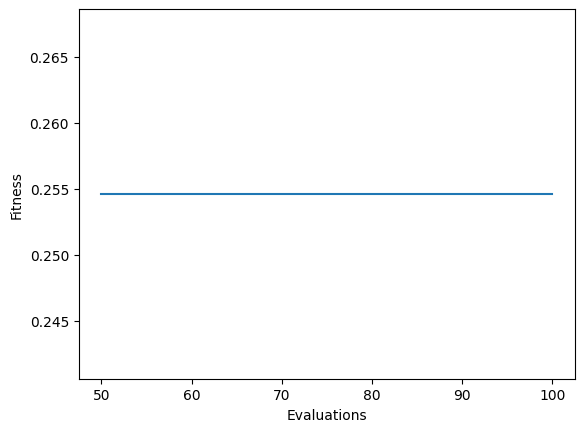

{'env_name': 'Walker-v0',
 'robot': [[0, 0, 0, 0, 0],
  [0, 3, 3, 3, 0],
  [0, 3, 3, 3, 0],
  [3, 3, 3, 4, 4],
  [3, 3, 0, 4, 3]],
 'n_in': 54,
 'h_size': 32,
 'n_out': 15,
 'genes': [1.552448564616094,
  0.45024695988935604,
  0.06820271423275631,
  -0.7618047608814624,
  -1.3938225942289795,
  -0.3459109048347236,
  0.9328080007966628,
  -1.4519052377281472,
  1.7313389779711743,
  0.6167699844323844,
  0.7373978950002192,
  -1.1114415091629322,
  1.6649093189576165,
  -0.3526153039534324,
  -0.5675091707563534,
  0.11952234579506653,
  -0.4313530791740471,
  0.36611407143493896,
  0.8183670666437854,
  0.8751404452640426,
  -1.4386620954798068,
  0.566242436734908,
  0.6360316621384552,
  0.5680491227277286,
  -0.6695092489893394,
  -0.33387489865228437,
  1.7619508590350932,
  -1.0251395844087676,
  0.9868305558839228,
  0.6505721852712123,
  -0.3261624654859546,
  0.9896448872888168,
  0.0709049851451855,
  -0.7073711066447473,
  0.727323872993151,
  -1.8695238147864726,
  -1.8733

In [53]:
walker = np.array([
    [0, 0, 0, 0, 0 ],
    [0, 3, 3, 3, 0],
    [0, 3, 3, 3, 0],
    [3, 3, 3, 4, 4],
    [3, 3, 0, 4, 3]
    ])



np.save("walker_matrix.npy", walker)


config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 2, # to change: increase!
    "lambda": 10, # Population size
    "mu": 50, # Parents pop size *ES*
    "sigma": 0.1, # mutation std
    "lr": 1, # Learning rate
    "max_steps": 100, # to change to 500
}

a = CMA_ME(config)
a.fitness

cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
cfg = {**config, **cfg} # Merge configs

env = make_env(config["env_name"], robot=config["robot"])
evaluate(a, env, render=False)
env.close()

np.save("Walker.npy", a.genes)

save_solution(a, cfg, name="solution.json")

In [51]:
# Assumendo che l'agente sia già stato creato e abbia una fitness calcolata
if a.fitness is not None:
    print(f"Fitness dell'agente: {a.fitness}")
else:
    print("⚠ La fitness dell'agente non è stata ancora calcolata!")

Fitness dell'agente: 1.6628175278097255


In [52]:
# Carica la soluzione e stampa la fitness
loaded_agent = load_solution("solution.json")

if loaded_agent.fitness is not None:
    print(f"Fitness dell'agente caricato: {loaded_agent.fitness}")
else:
    print("⚠ La fitness dell'agente caricato non è stata ancora calcolata!")

Fitness dell'agente caricato: 1.6628175278097255
